In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
image_shape = (28, 28)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 128

# trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2, drop_last=True)

# testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2, drop_last=True)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [4]:
import sys
sys.path.append('/home/oralph/repos/fashion-mnist')

In [5]:
from utils import mnist_reader

In [6]:
data_path = '/home/oralph/repos/fashion-mnist/data/fashion'
X, y = mnist_reader.load_mnist(data_path, kind='train')
X_test, y_test = mnist_reader.load_mnist(data_path, kind='t10k')

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=0)

In [8]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [9]:
X_train[0].shape

(784,)

In [10]:
image = X_train[0].reshape((28, 28))

In [11]:
image.shape

(28, 28)

In [12]:
image = transform(image)

In [13]:
image

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [14]:
y_train[0]

7

In [15]:
from torch.utils.data import Dataset

class CustomFashionMNISTDataset(Dataset):
    def __init__(self, images, labels, image_shape, image_transform):
        self.images = images
        self.labels = labels
        self.image_shape = image_shape
        self.image_transform = image_transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        image = self.images[i].reshape(self.image_shape)
        label = self.labels[i]

        if self.image_transform:
            image = self.image_transform(image)
        
        return image, label

In [16]:
from torch.utils.data import DataLoader

train_dataset = CustomFashionMNISTDataset(X_train, y_train, transform, image_shape)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = CustomFashionMNISTDataset(X_val, y_val, transform, image_shape)

val_dataloader = DataLoader(val_dataset, batch_size)

test_dataset = CustomFashionMNISTDataset(X_test, y_test, transform, image_shape)

test_dataloader = DataLoader(test_dataset, batch_size)

In [17]:
train_dataset.__getitem__(0)

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

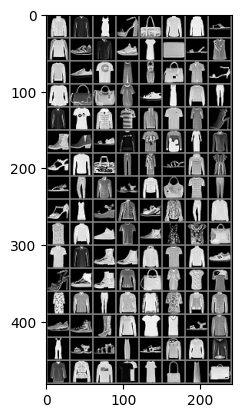

Coat  Shirt Dress Sandal Bag   Shirt Pullover Sandal Shirt Sneaker Shirt Sneaker Dress Bag   Sandal Shirt Pullover Sneaker T-shirt/top T-shirt/top Dress Bag   Shirt Sandal Pullover Bag   Bag   Dress Sneaker Dress Pullover Trouser Shirt T-shirt/top Coat  T-shirt/top Coat  T-shirt/top Dress Sandal Ankle Boot Ankle Boot Sandal Pullover T-shirt/top Pullover Dress Shirt Sandal Pullover Bag   Trouser Coat  Sandal Pullover Dress Sandal Trouser Shirt Sandal Coat  Bag   T-shirt/top Trouser Sandal Dress Sandal Coat  Sandal Shirt Trouser Pullover Shirt Coat  Sneaker T-shirt/top Ankle Boot Dress T-shirt/top Bag   T-shirt/top Shirt Ankle Boot Ankle Boot Coat  T-shirt/top Coat  Sneaker Sandal Sneaker Ankle Boot Pullover Bag   Dress Shirt T-shirt/top Dress Shirt Trouser Coat  Shirt T-shirt/top Coat  Shirt Sneaker Sneaker Ankle Boot Shirt T-shirt/top Pullover Sandal Shirt Trouser Sandal Sandal Dress Sandal Coat  Shirt Pullover Shirt Coat  Pullover T-shirt/top Dress Bag   Dress Bag  


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(image):
    image = image / 2 + 0.5     # unnormalize
    np_image = image.numpy()    # convert back from tensor
    plt.imshow(np.transpose(np_image, (1, 2, 0)))   # transpose image to correct shape for visualisation
    plt.show()


# get some random training images
images, labels = next(iter(train_dataloader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [19]:
# Examine a sample
images, labels = next(iter(train_dataloader))
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([128, 1, 28, 28])
torch.Size([128])


In [20]:
# Examine a sample
images, labels = next(iter(val_dataloader))
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([128, 1, 28, 28])
torch.Size([128])


In [21]:
# Examine a sample
images, labels = next(iter(test_dataloader))
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([128, 1, 28, 28])
torch.Size([128])


/home/oralph/.venv/lib/python3.12/site-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [22]:
from torchvision.models import resnet18, resnet34, resnet50
from torch import nn
model = resnet18(weights=None).to(device)

# Convert model to grayscale
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)

# Update the fully connected layer based on the number of classes in the dataset
model.fc = torch.nn.Linear(model.fc.in_features, len(classes)).to(device)


In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [24]:
for epoch in range(2):  # loop over the dataset multiple times
    # initiate model training
    print(f'Training - epoch: {epoch}')
    model.train()

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    # initiate model validation
    print(f'Validation - epoch {epoch}')
    model.eval()

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in val_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

print('Finished Training')

Training - epoch: 0
[1,   100] loss: 0.904
[1,   200] loss: 0.490
[1,   300] loss: 0.444
Validation - epoch 0
Accuracy of the network on the 10000 test images: 84 %
Training - epoch: 1
[2,   100] loss: 0.362
[2,   200] loss: 0.340
[2,   300] loss: 0.335
Validation - epoch 1
Accuracy of the network on the 10000 test images: 86 %
Finished Training


In [25]:
PATH = './fashion_mnist_model.pth'
torch.save(model.state_dict(), PATH)

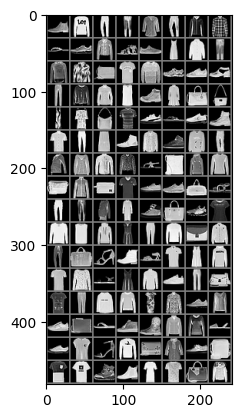

GroundTruth:  Ankle Boot Pullover Trouser Trouser


In [27]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(test_dataloader))

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [28]:
model = resnet18(weights=None).to(device)

# Convert model to grayscale
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)

# Update the fully connected layer based on the number of classes in the dataset
model.fc = torch.nn.Linear(model.fc.in_features, len(classes)).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [29]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Pullover Bag   Sandal Bag  


In [31]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 85 %


In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: T-shirt/top is 77.8 %
Accuracy for class: Trouser is 94.8 %
Accuracy for class: Pullover is 76.0 %
Accuracy for class: Dress is 87.6 %
Accuracy for class: Coat  is 72.4 %
Accuracy for class: Sandal is 95.9 %
Accuracy for class: Shirt is 63.9 %
Accuracy for class: Sneaker is 90.7 %
Accuracy for class: Bag   is 95.8 %
Accuracy for class: Ankle Boot is 95.4 %
